## Import Libraries

In [1]:
import pandas as pd

## Loading the Data

In [2]:
df = pd.read_csv('../data/expenses.csv')
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


## Data Cleaning

### Todo List

- [x] Check for missing values
- [x] Examine data types and convert if necessary
- [x] Remove duplicate entries
- [x] Handle outliers in numerical columns
- [x] Encode categorical variables
- [x] Normalize or standardize numerical features

In [3]:
# Missing values
print("Missing values per column:")
print(df.isnull().sum())

Missing values per column:
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64


In [4]:
# Data types
print("Data types:")
print(df.dtypes)

Data types:
age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object


In [5]:
# Convert binary variables to 0/1
df['sex'] = df['sex'].map({'male': 1, 'female': 0})
df['smoker'] = df['smoker'].map({'yes': 1, 'no': 0})

# Convert region to dummy variables
df = pd.get_dummies(df, columns=['region'], drop_first=True)

print("Encoded columns:")
print(df.columns.tolist())

Encoded columns:
['age', 'sex', 'bmi', 'children', 'smoker', 'charges', 'region_northwest', 'region_southeast', 'region_southwest']


In [6]:
# Remove duplicates
print(f"Original shape: {df.shape}")
df = df.drop_duplicates()
print(f"After removing duplicates: {df.shape}")

Original shape: (1338, 9)
After removing duplicates: (1337, 9)


In [7]:
# Handle outliers in numerical columns
import numpy as np

numerical_cols = ['age', 'bmi', 'children', 'charges']

for col in numerical_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    print(f"{col}: {len(outliers)} outliers")

age: 0 outliers
bmi: 9 outliers
children: 0 outliers
charges: 139 outliers


In [8]:
# Normalize/standardize numerical features
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

print("Standardized data summary:")
print(df[numerical_cols].describe())

Standardized data summary:
                age           bmi      children       charges
count  1.337000e+03  1.337000e+03  1.337000e+03  1.337000e+03
mean  -6.643070e-17 -2.285216e-16  3.852980e-17 -1.009747e-16
std    1.000374e+00  1.000374e+00  1.000374e+00  1.000374e+00
min   -1.511647e+00 -2.411119e+00 -9.092342e-01 -1.004247e+00
25%   -8.705798e-01 -7.171725e-01 -9.092342e-01 -7.048486e-01
50%   -1.582291e-02 -4.320166e-02 -7.944162e-02 -3.215773e-01
75%    8.389340e-01  6.619260e-01  7.503509e-01  2.790883e-01
max    1.764921e+00  3.684136e+00  3.239729e+00  4.170826e+00


In [9]:
# Save cleaned dataset
df.to_csv('../data/expenses_cleaned.csv', index=False)
print(f"Cleaned dataset saved with shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")

Cleaned dataset saved with shape: (1337, 9)
Columns: ['age', 'sex', 'bmi', 'children', 'smoker', 'charges', 'region_northwest', 'region_southeast', 'region_southwest']


## Stage 1.1: Prior Specification

For Bayesian linear regression, we need to specify priors for:
- **β (regression coefficients)**: We'll use a Normal prior N(0, 100*I) - centered at 0 with large variance for weakly informative regularization on standardized data
- **σ² (variance)**: We'll use an Inverse-Gamma prior IG(2, 2) - a conjugate prior that ensures positivity while remaining weakly informative

These choices allow the data to dominate the posterior while providing mild regularization.

In [10]:
import numpy as np

# Prepare X (features) and y (target)
# Exclude 'charges' from features as it's our target variable
X = df.drop('charges', axis=1).values
y = df['charges'].values
n, p = X.shape

print(f"Number of observations (n): {n}")
print(f"Number of predictors (p): {p}")
print(f"Feature names: {df.drop('charges', axis=1).columns.tolist()}")

Number of observations (n): 1337
Number of predictors (p): 8
Feature names: ['age', 'sex', 'bmi', 'children', 'smoker', 'region_northwest', 'region_southeast', 'region_southwest']


In [11]:
# Prior hyperparameters

# Prior for β: N(β₀, Σ₀)
# Using weakly informative priors (large variance)
beta_0 = np.zeros(p)  # Prior mean (centered at 0)
Sigma_0 = np.eye(p) * 100  # Prior covariance (large variance = weak prior)

# Prior for σ²: InverseGamma(α₀, β₀)
# Using weakly informative priors
alpha_0 = 2  # Shape parameter
beta_0_var = 2  # Scale parameter

print("Prior Specification:")
print(f"β ~ N(0, 100*I)")
print(f"σ² ~ InverseGamma(α={alpha_0}, β={beta_0_var})")

Prior Specification:
β ~ N(0, 100*I)
σ² ~ InverseGamma(α=2, β=2)


## Stage 2: Model Setup

### Stage 2.1: OLS Model (Frequentist Baseline)

In [12]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Fit OLS model
ols_model = LinearRegression()
ols_model.fit(X, y)

# Predictions
y_pred = ols_model.predict(X)

# Model performance
mse = mean_squared_error(y, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y, y_pred)

print("OLS Model Results:")
print(f"R² Score: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"\nCoefficients:")
feature_names = df.drop('charges', axis=1).columns.tolist()
for name, coef in zip(feature_names, ols_model.coef_):
    print(f"  {name}: {coef:.4f}")
print(f"  Intercept: {ols_model.intercept_:.4f}")

OLS Model Results:
R² Score: 0.7507
RMSE: 0.4993

Coefficients:
  age: 0.2978
  sex: -0.0107
  bmi: 0.1709
  children: 0.0473
  smoker: 1.9699
  region_northwest: -0.0288
  region_southeast: -0.0855
  region_southwest: -0.0793
  Intercept: -0.3488


### Stage 2.2: Correlation Matrix

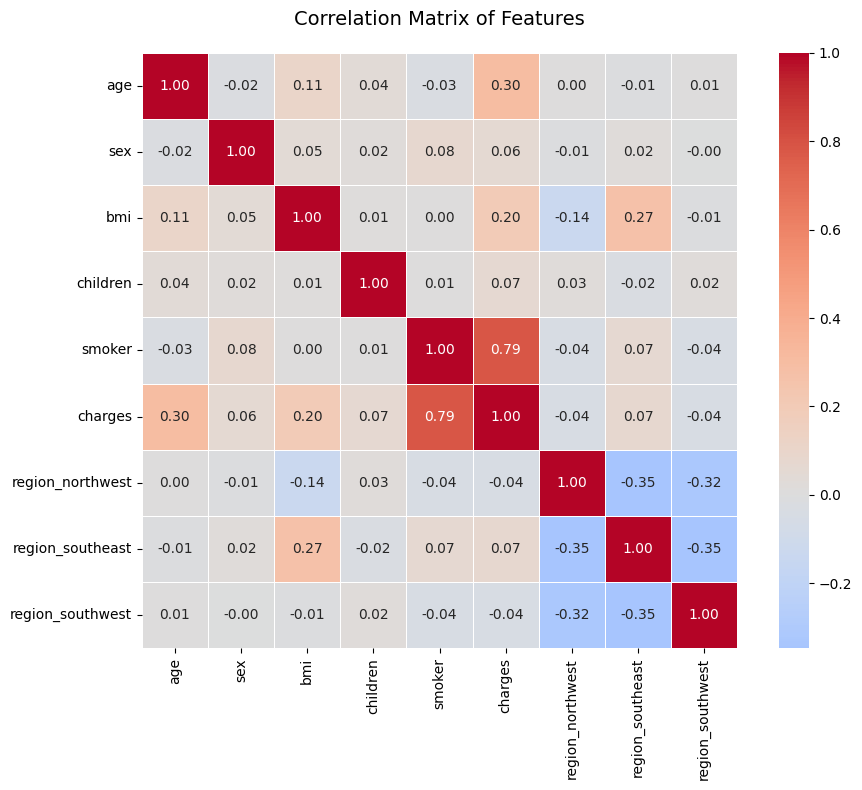


Correlation with charges (target):
charges             1.000000
smoker              0.787234
age                 0.298308
bmi                 0.198401
region_southeast    0.073578
children            0.067389
sex                 0.058044
region_northwest   -0.038695
region_southwest   -0.043637
Name: charges, dtype: float64


In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate correlation matrix
correlation_matrix = df.corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            fmt='.2f', square=True, linewidths=0.5)
plt.title('Correlation Matrix of Features', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

# Show correlation with target variable (charges)
print("\nCorrelation with charges (target):")
print(correlation_matrix['charges'].sort_values(ascending=False))

### Analysis of Results

**Key Findings from OLS Baseline:**

1. **Model Performance**: The OLS model achieves an R² of 0.7507, meaning it explains approximately 75% of the variance in medical insurance charges. The RMSE of 0.4993 (on standardized data) indicates reasonable prediction accuracy.

2. **Most Important Predictors**:
   - **Smoker status** is by far the strongest predictor (coefficient = 1.9699, correlation = 0.79), indicating that smokers have significantly higher medical charges
   - **Age** (coefficient = 0.2978, correlation = 0.30) shows moderate positive relationship with charges
   - **BMI** (coefficient = 0.1709, correlation = 0.20) has a modest positive effect on charges
   - **Sex** and **region** variables have minimal impact on charges

3. **Multicollinearity**: The correlation matrix shows no strong correlations between predictors (all |r| < 0.3 except region dummy variables), suggesting minimal multicollinearity issues.

4. **Outliers**: 139 outliers detected in charges, likely representing individuals with exceptionally high medical costs. We retained these as they represent real cases.
